In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import utils.eval_funcs as eval_funcs
import matplotlib.colors 
import json

In [3]:

plt.rcParams["font.family"] = "Liberation Serif"
plt.rcParams["font.weight"] = "bold"
plot_cfg = {
    "tick_label_size" : 50,
    "xlabel_size" : 60,
    "ylabel_size" : 60,
    "border_size" : 6,
    "bar_border_size" : 2.5,
    "bar_label_size" : 32,
    "stars_label_size" : 48,
    "annot_size" : 72,
    "max_cm_classes" : 4,
    "legend_size" : 42,
    "max_bars" : 4
}

# Lethals in the TGI Dataset

In [4]:
smf_df = pd.read_csv('../generated-data/task_yeast_smf_30')
lethal_genes = set(smf_df[smf_df['bin'] == 0]['gene'])

In [5]:
tgi_df = pd.read_csv('../generated-data/task_yeast_tgi')

In [6]:
tgi_genes = set(tgi_df['a']) | set(tgi_df['b']) | set(tgi_df['c'])

In [7]:
print("Lethals: %d" % len(lethal_genes))
print("Genes in TGI: %d" % len(tgi_genes))
print("Lethal genes in TGI: %d" % len(lethal_genes.intersection(tgi_genes)))

Lethals: 839
Genes in TGI: 1300
Lethal genes in TGI: 226


# SGO Terms

In [8]:
d = np.load('../generated-data/features/ppc_yeast_common_sgo.npz')

In [9]:
F = d['F']
terms = d['feature_labels']

with open('../generated-data/go_ids_to_names.json', 'r') as f:
    gene_ids_to_terms = json.load(f)

terms = [gene_ids_to_terms[t] for t in terms]

In [10]:
neg_df = tgi_df[tgi_df['bin'] == 0]

In [73]:
n_terms_shared = [[], []]
zero_terms = [0, 0]
for a_id, b_id, c_id, thebin in zip(tgi_df['a_id'], tgi_df['b_id'], tgi_df['c_id'], tgi_df['bin']):
    a_terms = F[a_id, :]
    b_terms = F[b_id, :]
    c_terms = F[c_id, :]
    thebin = int(thebin)
    
    shared = []
    for i in range(1, 4):
        n = np.sum((a_terms + b_terms + c_terms) >= i)
        shared.append(n)
    
    n_terms_shared[thebin].append(shared)
    
    n_zero_terms = np.sum((a_terms + b_terms + c_terms) == 0) == F.shape[1]
    zero_terms[thebin] += n_zero_terms 
zero_terms

[2, 76]

In [74]:
neg_n_terms = np.array(n_terms_shared[0])
net_n_terms = np.array(n_terms_shared[1])
colors = ['magenta', 'cyan']
star_colors = ['magenta', '#007bff']

In [75]:

def chi2(f_obs):

    # compute expected frequencies
    col_marginal = np.sum(f_obs, axis=1, keepdims=True)
    row_marginal = np.sum(f_obs, axis=0, keepdims=True)
    total = np.sum(row_marginal)
    f_exp = np.dot(col_marginal / total, row_marginal)
    
    
    print(f_obs)
    print(col_marginal)
    print(row_marginal)
    print(f_exp)
    
    chisq, p = stats.chisquare(f_obs, f_exp, axis=None)
    
    ddof = (f_obs.shape[0]-1) * (f_obs.shape[1]-1)

    return chisq, p, ddof

def calculateR(threshold):
    
    max_N = np.maximum(np.max(neg_n_terms[:,threshold-1]), np.max(net_n_terms[:,threshold-1]))
    R = np.zeros((2, max_N+1))
    for thebin in [0, 1]:
        class_terms = neg_n_terms if thebin == 0 else net_n_terms
        for n_terms_shared in range(R.shape[1]):
            R[thebin, n_terms_shared] = np.sum(class_terms[:,threshold-1] == n_terms_shared)
    return R
def visualizeR(R, ax, output_path, title, showxlabel=True, yticks=None):
    MAX_TERMS_SHARED = 6
    rows = []
    bin_labels = ['Negative', 'Neutral']
    for thebin in range(R.shape[0]):
        for n_terms_shared in range(MAX_TERMS_SHARED):
            if n_terms_shared < R.shape[1]:
                freq = R[thebin, n_terms_shared] * 100 / np.sum(R[thebin, :])
            else:
                freq = 0
            rows.append({
                "bin" : bin_labels[thebin],
                "n_terms_shared" : n_terms_shared,
                "freq" : freq 
            })
    df = pd.DataFrame(rows)
    
    g = sns.barplot(x="n_terms_shared", 
            y="freq", 
            hue="bin",
            ax=ax,
            data=df, 
            palette=['magenta', 'cyan'])
    
    if yticks is not None:
        ax.set_yticks(yticks)
        
    ax.yaxis.set_tick_params(labelsize=plot_cfg['tick_label_size'])
    ax.xaxis.set_tick_params(labelsize=plot_cfg['tick_label_size'])
    #ax.set_ylabel("% Triplets", fontsize=plot_cfg['ylabel_size'], fontweight='bold')
    ax.set_ylabel("")
    if showxlabel:
        ax.set_xlabel("Number of Shared sGO Terms", fontsize=plot_cfg['ylabel_size']*0.75, fontweight='bold')
    else:
        ax.set_xlabel("")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.legend(frameon=False, fontsize=plot_cfg['legend_size'], bbox_to_anchor=(0.99,0.99))
    plt.setp(ax.spines.values(),linewidth=plot_cfg["border_size"], color='black')
    chisq, p, ddof = chi2(R)
    stars = '*' * eval_funcs.compute_stars(p, 0.05)
    ax.text(0.48, 0.82, stars, 
                    transform=ax.transAxes,
                    color=star_colors[1], ha="left", va="top", weight='bold', 
                    fontsize=plot_cfg['stars_label_size'])
    ax.set_title(title, fontsize=plot_cfg['xlabel_size'], fontweight='bold')
    #plt.savefig(output_path, bbox_inches='tight', dpi=100)



[[1.1870e+03 1.1640e+03 4.3100e+02 4.4000e+01 7.0000e+00 2.0000e+00]
 [2.9725e+04 2.9972e+04 1.0625e+04 1.1990e+03 1.0600e+02 1.0000e+00]]
[[ 2835.]
 [71628.]]
[[3.0912e+04 3.1136e+04 1.1056e+04 1.2430e+03 1.1300e+02 3.0000e+00]]
[[1.17690021e+03 1.18542847e+03 4.20930664e+02 4.73242416e+01
  4.30220378e+00 1.14217799e-01]
 [2.97350998e+04 2.99505715e+04 1.06350693e+04 1.19567576e+03
  1.08697796e+02 2.88578220e+00]]
[[2.2110e+03 5.5200e+02 7.1000e+01 1.0000e+00]
 [6.0249e+04 1.0523e+04 8.3800e+02 1.8000e+01]]
[[ 2835.]
 [71628.]]
[[6.2460e+04 1.1075e+04 9.0900e+02 1.9000e+01]]
[[2.37801458e+03 4.21654043e+02 3.46079932e+01 7.23379396e-01]
 [6.00819854e+04 1.06533460e+04 8.74392007e+02 1.82766206e+01]]


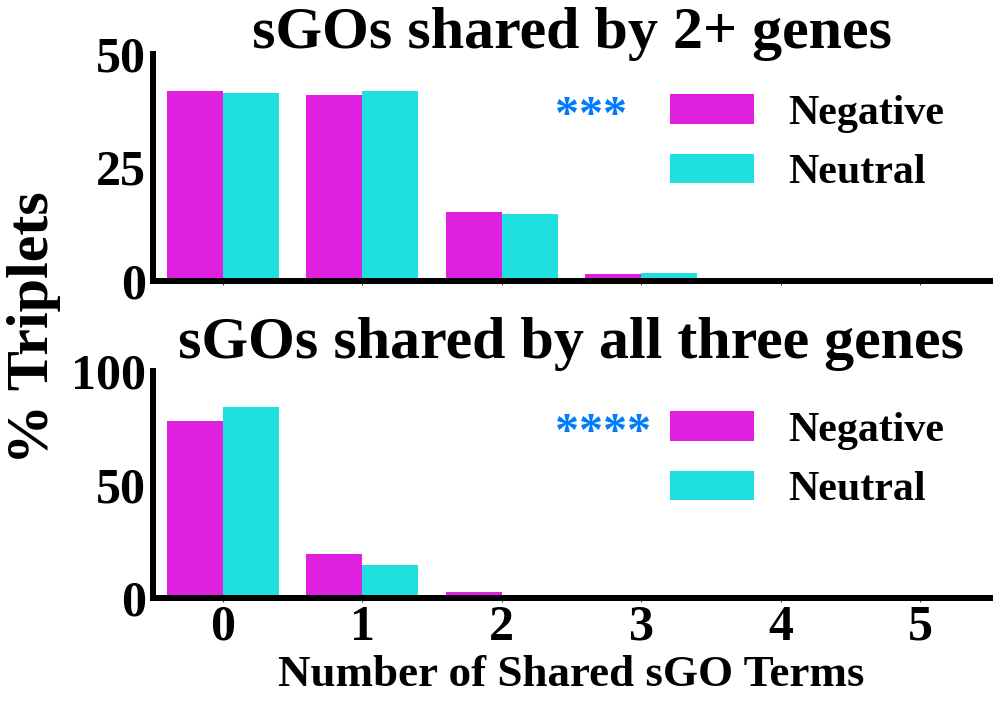

In [76]:

R2 = calculateR(2)

R3 = calculateR(3)

f, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
visualizeR(R2, axes[0], "../figures/yeast_tgi_sgo_atleast2.png", "sGOs shared by 2+ genes", showxlabel=False, yticks=[0, 25, 50])
visualizeR(R3, axes[1], "../figures/yeast_tgi_sgo_all3.png", "sGOs shared by all three genes", yticks=[0, 50, 100])
f.text(-0.01, 0.5, '% Triplets', va='center', rotation='vertical', fontsize=plot_cfg['ylabel_size'], fontweight='bold')
f.subplots_adjust(hspace=0.4)

# chisq, p, ddof = chi2(R)
# print("Chi2: %f, p value: %f, ddof: %d" % (chisq, p, ddof))


# Shortest Path Length

In [14]:
d = np.load('../generated-data/pairwise_features/ppc_yeast_shortest_path_len.npy')

In [15]:
avg_spls = [[], []]
for a_id, b_id, c_id, thebin in zip(tgi_df['a_id'], tgi_df['b_id'], tgi_df['c_id'], tgi_df['bin']):
    
    thebin = int(thebin)
    
    ab_spl = d[a_id, b_id]
    ac_spl = d[a_id, c_id]
    bc_spl = d[b_id, c_id]
    avg_spl = np.sum([ab_spl, ac_spl, bc_spl])
    avg_spls[thebin].append(avg_spl)
    

In [16]:
print(stats.ttest_ind(avg_spls[0], avg_spls[1]))
print(np.mean(avg_spls[0]))
print(np.mean(avg_spls[1]))
stats.ks_2samp(avg_spls[0], avg_spls[1])

Ttest_indResult(statistic=-2.823137043498752, pvalue=0.0047568851958635465)
8.102998236331569
8.194812084659631


Ks_2sampResult(statistic=0.06992438592930023, pvalue=5.241697476948817e-12)

[ 3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16.]
[ 3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.]


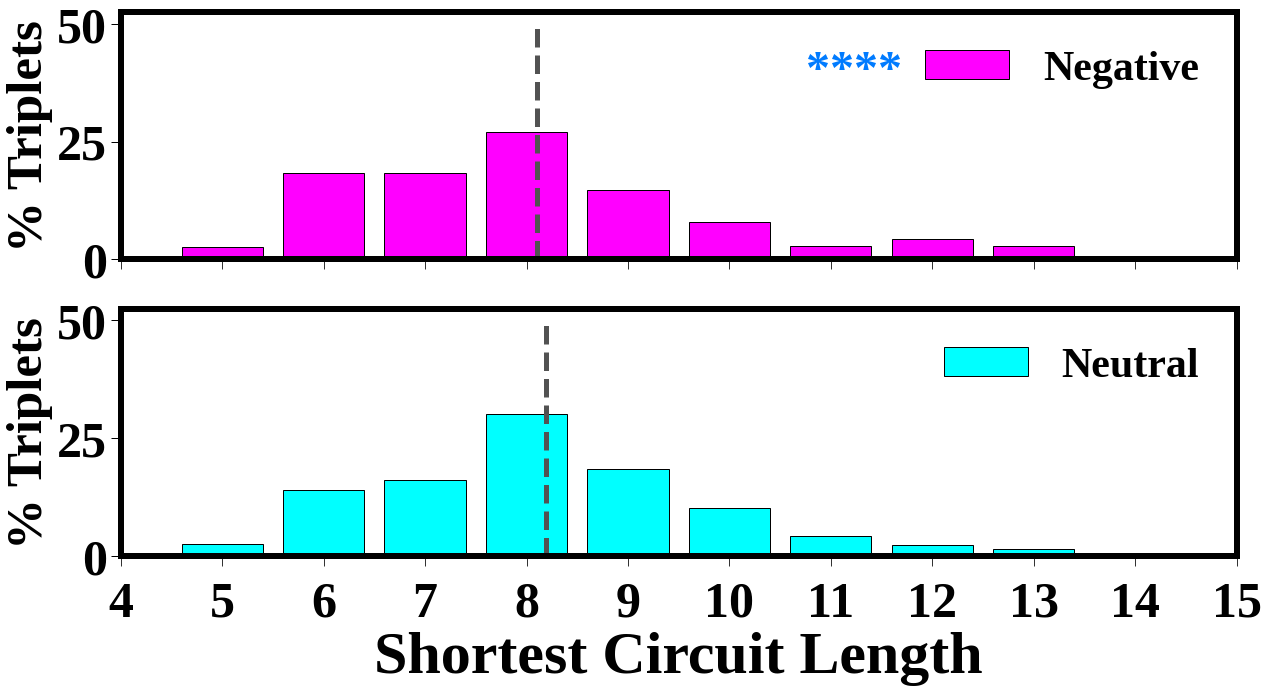

In [21]:
f, axes = plt.subplots(2, 1, figsize=(20, 10), sharex=True)

max_circuit_length = np.maximum(np.max(avg_spls[0]), np.max(avg_spls[1]))
min_circuit_length = np.minimum(np.min(avg_spls[0]), np.min(avg_spls[1]))
bin_labels = ['Negative', 'Neutral']
for i in [0, 1]:
    spls = avg_spls[i]
    ax = axes[i]
    
    labels, counts = np.unique(spls, return_counts=True)
    ax.bar(labels, counts * 100 / np.sum(counts), align='center', color=colors[i], edgecolor='black', label=bin_labels[i])
    ax.set_xticks(labels)

#     ax.hist(spls, bins=np.arange(min_circuit_length, max_circuit_length), 
#             color=colors[i], 
#             edgecolor='black',
#             label=bin_labels[i],
#             align='center',
#             weights=np.ones(len(spls)) * 100 / len(spls))
    
    mean_spl = np.mean(spls)
    
    ax.plot([mean_spl, mean_spl], [0, 50], linewidth=5, color='#525252', linestyle='--')
    ax.yaxis.set_tick_params(labelsize=plot_cfg['tick_label_size'])
    ax.xaxis.set_tick_params(labelsize=plot_cfg['tick_label_size'])
    ax.set_ylabel('% Triplets', fontsize=plot_cfg['ylabel_size']*0.85, weight='bold')
    ax.yaxis.set_tick_params(length=10, width=1, which='both')
    ax.xaxis.set_tick_params(length=10, pad=15)
    ax.set_yticks([0, 25, 50])
    ax.set_xlim([4,15])
    ax.set_xticks(np.arange(4,16))
    ax.legend(frameon=False, fontsize=plot_cfg['legend_size'])
    
    #ax.set_title(bin_labels[i], fontsize=plot_cfg['xlabel_size'])
    if i == 1:
        ax.set_xlabel('Shortest Circuit Length', fontsize=plot_cfg['xlabel_size'], weight='bold')
    plt.setp(axes[i].spines.values(),linewidth=plot_cfg["border_size"], color='black')
    
    if i == 0:
        yoffset = 0.85
        xoffset = 0.7
        statistic, pvalue = stats.ks_2samp(avg_spls[0], avg_spls[1])
        target_color = star_colors[i+1]
        stars = '*' * eval_funcs.compute_stars(pvalue, 0.05)
        axes[i].text(xoffset, yoffset, stars, 
                    transform=axes[i].transAxes,
                    color=target_color, ha="right", va="top", weight='bold', 
                    fontsize=plot_cfg['stars_label_size'])

plt.savefig("../figures/yeast_tgi_shortest_circuit_len.png", bbox_inches='tight', dpi=100)


[[ 1124   943]
 [23390 26719]]
[[ 2067]
 [50109]]
[[24514 27662]]
[[  971.14454922  1095.85545078]
 [23542.85545078 26566.14454922]]
47.25200415594744   3.072015668544941e-10


Text(0.4, 0.83, '****')

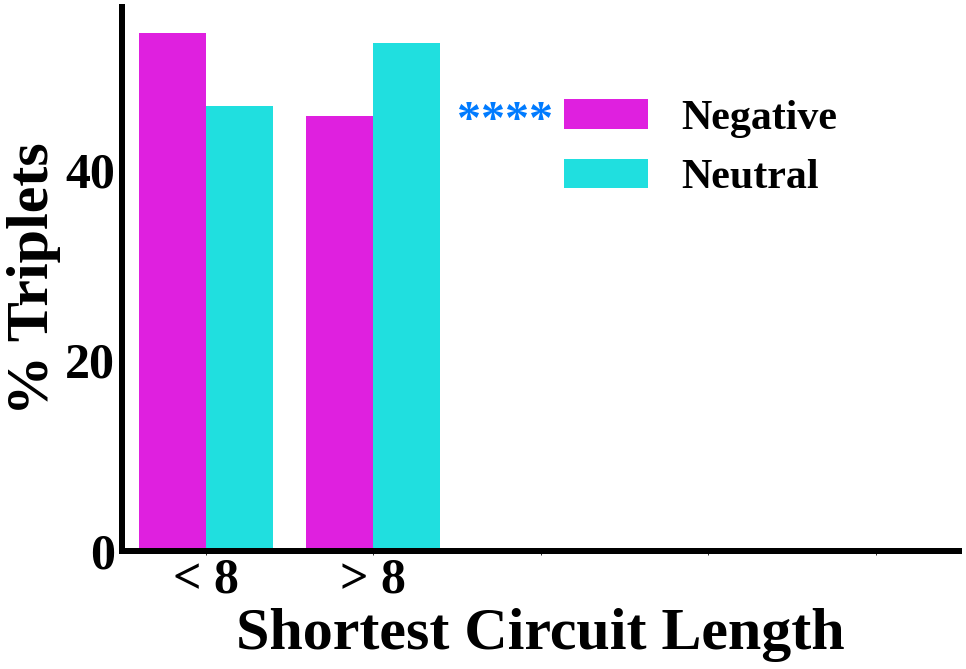

In [24]:

cutoff = 8
R = np.array([
    [ np.sum(np.array(avg_spls[0]) < cutoff), np.sum(np.array(avg_spls[0]) >= 8) ],
    [ np.sum(np.array(avg_spls[1]) < cutoff), np.sum(np.array(avg_spls[1]) >= 8) ],
])

rows = []
bin_labels = ['Negative', 'Neutral']
for thebin in range(R.shape[0]):
    for k, lbl in enumerate(['< %d' % cutoff, '≥ %d' % cutoff, '  ', '    ', '     ']):
        if k >= 2:
            freq = 0
        else:
            freq = R[thebin, k] * 100 / np.sum(R[thebin, :])
        rows.append({
            "bin" : bin_labels[thebin],
            "circuit_len" : lbl,
            "freq" : freq
        })
df = pd.DataFrame(rows)
f, ax = plt.subplots(1, 1, figsize=(15, 10))
g = sns.barplot(x="circuit_len", 
        y="freq", 
        hue="bin",
        ax=ax,
        data=df, 
        palette=['magenta', 'cyan'])

ax.yaxis.set_tick_params(labelsize=plot_cfg['tick_label_size'])
ax.xaxis.set_tick_params(labelsize=plot_cfg['tick_label_size'])
ax.set_ylabel("% Triplets", fontsize=plot_cfg['ylabel_size'], fontweight='bold')
ax.set_xlabel("Shortest Circuit Length", fontsize=plot_cfg['ylabel_size'], fontweight='bold')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(frameon=False, fontsize=plot_cfg['legend_size'], bbox_to_anchor=(0.9,0.9))
plt.setp(ax.spines.values(),linewidth=plot_cfg["border_size"], color='black')

chisq, p, ddof = chi2(R)
print(chisq, ' ', p)
stars = '*' * eval_funcs.compute_stars(p, 0.05)
ax.text(0.4, 0.83, stars, 
        transform=ax.transAxes,
        color=star_colors[1], ha="left", va="top", weight='bold', 
        fontsize=plot_cfg['stars_label_size'])

In [43]:
directly_conn = [[], []]
for a_id, b_id, c_id, thebin in zip(tgi_df['a_id'], tgi_df['b_id'], tgi_df['c_id'], tgi_df['bin']):
    
    thebin = int(thebin)
    
    ab_spl = d[a_id, b_id]
    ac_spl = d[a_id, c_id]
    bc_spl = d[b_id, c_id]
    
    dc = 0
    if ab_spl == 1 or ac_spl == 1 or bc_spl == 1:
        dc =1
    
    directly_conn[thebin].append(dc)


6532

[[  284  2551]
 [ 6532 65096]]
[[ 2835]
 [71628]]
[[ 6816 67647]]
[[  259.50284034  2575.49715966]
 [ 6556.49715966 65071.50284034]]
2.64629978894633   0.44943035003696064


Text(0.4, 0.83, '')

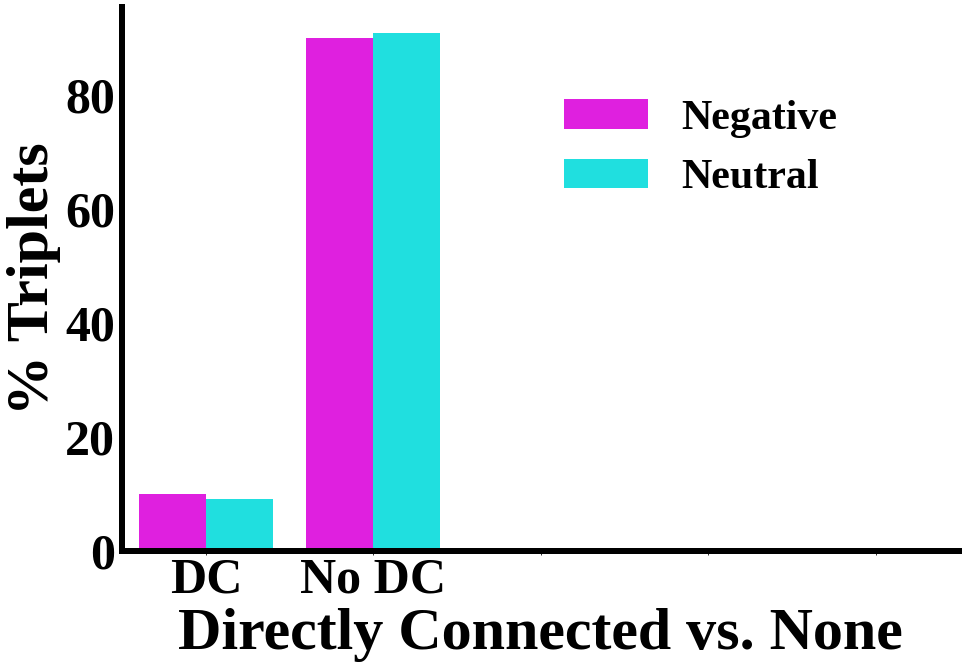

In [44]:

R = np.array([
    [ np.sum(np.array(directly_conn[0]) == 1), np.sum(np.array(directly_conn[0]) < 1) ],
    [ np.sum(np.array(directly_conn[1]) == 1), np.sum(np.array(directly_conn[1]) < 1) ],
])

rows = []
bin_labels = ['Negative', 'Neutral']
for thebin in range(R.shape[0]):
    for k, lbl in enumerate(['DC', 'No DC', '  ', '    ', '     ']):
        if k >= 2:
            freq = 0
        else:
            freq = R[thebin, k] * 100 / np.sum(R[thebin, :])
        rows.append({
            "bin" : bin_labels[thebin],
            "circuit_len" : lbl,
            "freq" : freq
        })
df = pd.DataFrame(rows)
f, ax = plt.subplots(1, 1, figsize=(15, 10))
g = sns.barplot(x="circuit_len", 
        y="freq", 
        hue="bin",
        ax=ax,
        data=df, 
        palette=['magenta', 'cyan'])

ax.yaxis.set_tick_params(labelsize=plot_cfg['tick_label_size'])
ax.xaxis.set_tick_params(labelsize=plot_cfg['tick_label_size'])
ax.set_ylabel("% Triplets", fontsize=plot_cfg['ylabel_size'], fontweight='bold')
ax.set_xlabel("Directly Connected vs. None", fontsize=plot_cfg['ylabel_size'], fontweight='bold')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(frameon=False, fontsize=plot_cfg['legend_size'], bbox_to_anchor=(0.9,0.9))
plt.setp(ax.spines.values(),linewidth=plot_cfg["border_size"], color='black')

chisq, p, ddof = chi2(R)
print(chisq, ' ', p)
stars = '*' * eval_funcs.compute_stars(p, 0.05)
ax.text(0.4, 0.83, stars, 
        transform=ax.transAxes,
        color=star_colors[1], ha="left", va="top", weight='bold', 
        fontsize=plot_cfg['stars_label_size'])

# sGO Visualization

[Text(0, 0, '-'), Text(1, 0, 'N')]

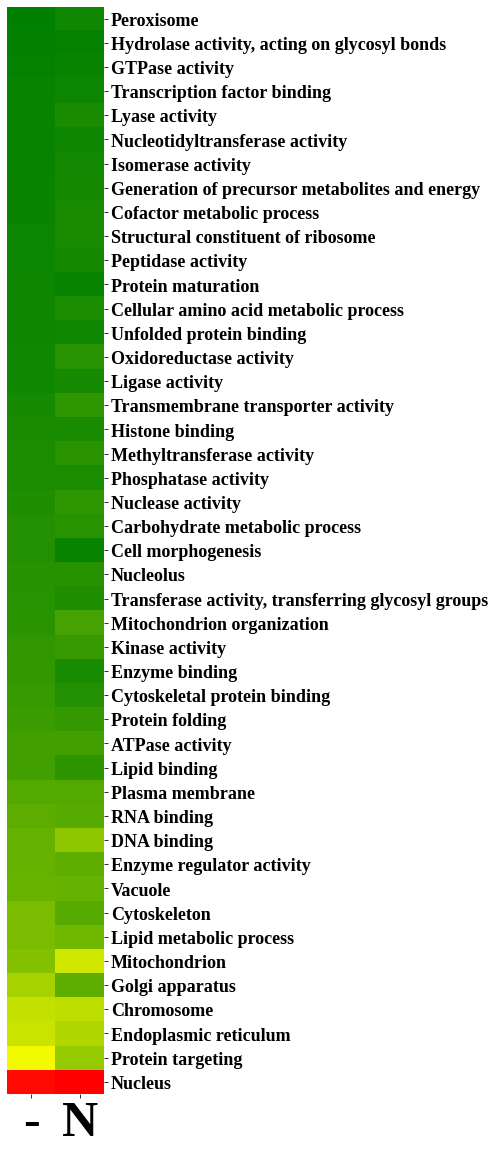

In [74]:
def make_label(s):
    return s[0].upper() + s[1:]

freq_by_term = np.zeros((F.shape[1], 2))
F = F.astype(bool)
for a_id, b_id, c_id, thebin in zip(tgi_df['a_id'], tgi_df['b_id'], tgi_df['c_id'], tgi_df['bin']):
    a_terms = F[a_id, :]
    b_terms = F[b_id, :]
    c_terms = F[c_id, :]
    thebin = int(thebin)
    
    union_of_terms = a_terms | b_terms | c_terms
    
    freq_by_term[union_of_terms, thebin] += 1

ix = np.argsort(freq_by_term[:,0])

freq_by_term = freq_by_term[ix, :]

f, ax = plt.subplots(1, 1, figsize=(10, 20))

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["green","yellow","red"])

vals = freq_by_term / np.sum(freq_by_term, axis=0, keepdims=True)
ax.yaxis.tick_right()
ax.imshow(vals, aspect=0.5, cmap=cmap)
plt.setp(ax.spines.values(), linewidth=0, color='black')
ax.set_yticks(np.arange(F.shape[1]))
ax.set_yticklabels(np.array([make_label(t) for t in terms])[ix], fontsize=18)
ax.set_xticks([0, 1])
ax.set_xticklabels(['-', 'N'], fontsize=plot_cfg['tick_label_size'])

# for i in range(vals.shape[0]):
#     for j in range(vals.shape[1]):
#         ax.text(j, i, '%0.1f' % vals[i,j], 
#                 color='black', ha="center", va="center", weight='bold', 
#                 fontsize=plot_cfg['tick_label_size'])

# Alleles in TGI Dataset

In [ ]:
tgi_df = pd.read_csv('../data-sources/yeast/aao1729_Data_S1.tsv', sep='\t')

In [ ]:
query_strains = set([s.split('_')[1] for s in tgi_df['Query strain ID']])
array_strains = set([s.split('_')[1] for s in tgi_df['Array strain ID']])

In [ ]:
len([a for a in array_strains if a.startswith('tsa')])

In [ ]:
len([a for a in query_strains if a.startswith('tsa')])